# Setup

### Importing libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from datetime import datetime

In [ ]:
prog_start=datetime.now()

### Installing Colab GPU

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing Huggingface Transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.9 MB/s eta 0:00:00


# Importing and manipulating data

Data form:
Training data is from 2008, for 5-14 August, each day being its own label 1-10.
Testing data is from 2022-23, for the ongoing war. The output for each article is a label for the 2008 data.

In [ ]:
df_2008=pd.read_csv('Tass2008.csv')

In [ ]:
df_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  1305 non-null   object
 1   Article   1305 non-null   object
 2   Date      1305 non-null   object
dtypes: object(3)
memory usage: 30.7+ KB


In [ ]:
df_2008['statement']=df_2008['Headline']+df_2008['Article']

In [ ]:
df_2008=df_2008.drop(['Headline','Article'],axis=1)

In [ ]:
df_2008.head()

,Date,statement
0,"Aug. 05, 2008",1400 Nevelsk families who lost homes in quake ...
1,"Aug. 05, 2008",2 % of inundated houses in western Ukraine ins...
2,"Aug. 05, 2008",600 children detained in Krasnodar for night -...
3,"Aug. 05, 2008","ALROSA, Diamond Chamber auction $31 milion wor..."
4,"Aug. 05, 2008",Ambassador denies alleged peacekeepers' involv...


In [ ]:
len(df_2008.Date.value_counts())

10

In [ ]:
date_dict={'Aug. 05, 2008':0,'Aug. 06, 2008':1,'Aug. 07, 2008':2,'Aug. 08, 2008':3,'Aug. 09, 2008':4,'Aug. 10, 2008':5,'Aug. 11, 2008':6,'Aug. 12, 2008':7,'Aug. 13, 2008':8,'Aug. 14, 2008':9}

In [ ]:
df_2008['label']=df_2008.Date.replace(date_dict)

# Data Manipulation and Tokenization

In [ ]:
statements=df_2008.statement.values
labels=df_2008.label.values
labels=labels.astype(int)

## Initializing the tokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

After importing the BertTokenizer, we run the method tokenizer.encode(), which does two things:
1. Tokenize the statement: Splitting the statement into tokens; each word and punctuation counts as one token.
2. Create Token IDs: The tokens are mapped to their indices in the tokenizer vocabulary.

When a statement is tokenized, two special tokens are added namely, [SEP] at the beginning and [CLS] at the end. Their relevance is explained in the report.


## Calculating maximum input id length

In [ ]:
max_len=0
for statm in statements:
    input_ids = tokenizer.encode(statm, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max input id length: ', max_len)

Max input id length:  200


As the maximum length is 200, we will take the next lowest power of 2 which is 256=2^8 as the maximum statement length for the model. This is to normalize the length for all statements; the empty spaces will be filled with the token [PAD], which is called padding. To complement padding, an array called the attention mask is created, which is the same length as the tokenized and padded statement; its elements represent whether there is a [PAD] at the corresponding index with the value 0, or not with the value 1.

## Complete tokenization process

To combine all our tasks, we will use **tokenizer.encode_plus()**. This function will return the the complete tokenized and padded statement, as well as the attention mask. It requires the following parameters:

1. Input sentence
2. Special tokens? True/False
3. Maximum sentence length
4. Padding? T/F
5. Return attention mask? T/F

**tokenizer.encode** does not return the attention mask, hence the need to use **tokenizer.encode_plus()**.

In [ ]:
start=datetime.now()
input_ids=[]
attention_masks=[]
for statm in statements:
    encoded_dict=tokenizer.encode_plus(
                            statm,
                            add_special_tokens = True,
                            max_length = 512,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print("Time: ",datetime.now()-start)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time:  0:00:03.323561


## Making the tensor dataset

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Making the Dataloaders
for training data and validation data

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [ ]:
for batch in validation_dataloader:
    print(batch)
    break

[tensor([[  101, 13661,  1011,  ...,     0,     0,     0],
        [  101,  4238,  7534,  ...,     0,     0,     0],
        [  101, 19021, 11129,  ...,     0,     0,     0],
        ...,
        [  101,  4895,  3036,  ...,     0,     0,     0],
        [  101,  4924,  8069,  ...,     0,     0,     0],
        [  101,  4895,  2007,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([2, 0, 5, 5, 1, 7, 1, 8, 9, 3, 1, 0, 4, 4, 1, 0])]


# BERT Training and Validation
There are several BERT models available for fine-tuning; the model we will be using is BertForSequenceClassification, as we are classifying statements, which are sequences of token ids.

## Initialization BERT model

The initialization of the model requires four parameters:

1. Name of pretrained model: We will be using the **bert-base-uncased**, which is the base BERT model with 12 transformers, and does not distinguish between the cases of letters.
2. Number of labels: The number of distinct label values.
3. Output attention? T/F
4. Output hidden states? T/F

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [ ]:
model=BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 10,
    output_attentions = False,
    output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#Command to run model on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Setting model hyperparameters

Once the model has been initialized, we need to set the training parameters as any neural network requires. They are listed below along with the recommendations of BERT authors:

1. Batch Size: 16,32
2. Adam(Learning rate): (2,3,5) e-5
3. Number of epochs: 2,3,4

Here are the parameter values we choose along with their reasons:
1. Batch size: 16. The lower values since the size of our dataset is not as large as many other sets used to fine tune bert.
2. Adam: 2e-5. The best results in NLP tasks are given by and adam value in between 2e-5 and 3e-5.
3. Number of epochs: 3. Computation costs increase with the no. of epochs. However, since our data set isn't very large, we didn't take the lowest value.


In [ ]:
optimizer=AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
from transformers import get_linear_schedule_with_warmup
epochs = 7
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Defining accuracy computation

about flat accuracy

In [ ]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    #print(preds,"\n",labels)
    return np.sum(preds == labels) / len(labels)

## The Training-Validation Loop

In [ ]:
start=datetime.now()
training_stats = []
for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()
    #Training
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        loss=result.loss
        logits=result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    #Validation
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].toa(device)
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits=result.logits
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )
print("Time: ",datetime.now()-start)

Time:  0:13:12.438483


In [ ]:
training_stats

[{'epoch': 1,
  'Training Loss': 2.2630900466764294,
  'Valid. Loss': 2.1825468805101185,
  'Valid. Accur.': 0.125},
 {'epoch': 2,
  'Training Loss': 1.8300936914779045,
  'Valid. Loss': 1.2817550169097052,
  'Valid. Accur.': 0.7708333333333334},
 {'epoch': 3,
  'Training Loss': 0.9241173609688476,
  'Valid. Loss': 0.43979078862402177,
  'Valid. Accur.': 1.0},
 {'epoch': 4,
  'Training Loss': 0.2985893587606984,
  'Valid. Loss': 0.09587811678647995,
  'Valid. Accur.': 1.0},
 {'epoch': 5,
  'Training Loss': 0.09642840131513171,
  'Valid. Loss': 0.04033861433466276,
  'Valid. Accur.': 1.0},
 {'epoch': 6,
  'Training Loss': 0.059294642679191926,
  'Valid. Loss': 0.029333847264448803,
  'Valid. Accur.': 1.0},
 {'epoch': 7,
  'Training Loss': 0.05012130994047668,
  'Valid. Loss': 0.026746764572130308,
  'Valid. Accur.': 1.0}]

# Predicting on 2022 data

## Importing and manipulating data

Data form:
Testing data is from 2022, for 01 Jan to 08 Jun, each day will be labelled 0-9, corresponding to the days of the 2008 war.

In [ ]:
df_2022=pd.read_csv('Tass2022.csv')

In [ ]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31965 entries, 0 to 31964
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  31965 non-null  object
 1   Article   31965 non-null  object
 2   Date      31965 non-null  object
dtypes: object(3)
memory usage: 749.3+ KB


In [ ]:
df_2022['statement']=df_2022['Headline']+df_2022['Article']

In [ ]:
df_2022=df_2022.drop(['Headline','Article'],axis=1)

In [ ]:
df_2022.tail()

,Date,statement
31960,"Jun. 08, 2022",IOC President Bach slams Wimbledon organizers ...
31961,"Jun. 08, 2022",Kiev plans to target Russian territory to prov...
31962,"Jun. 08, 2022",Explosion reported near US Consulate in Iraq's...
31963,"Jun. 08, 2022","TASS news roundup, 22.00 Moscow time, June 8....."
31964,"Jun. 08, 2022",Unidentified plane crosses airspace of four Eu...


In [ ]:
statements = df_2022.statement.values
dates = df_2022.Date.values

In [ ]:
max_len=0
for statm in statements:
    input_ids = tokenizer.encode(statm, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max input id length: ', max_len)

Max input id length:  327


## Data preparation
The data has to be tokenized and formatted in the same way as the training data.

In [ ]:
start=datetime.now()
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

for statm in statements:
    encoded_dict = tokenizer.encode_plus(
                        statm,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # Add attention mask to the list
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.
batch_size = 16

# Create the DataLoader.
test_data = TensorDataset(input_ids, attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

print("Time: ",datetime.now()-start)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time:  0:01:32.300289


## Making predictions on test set

With the test set in hand, the data undergoes a forward pass, but unlike while training the there is no gradient calculation as the weights are not to be updated.

In [ ]:
start=datetime.now()

model.eval()
i=0
predictions = np.empty([0,0])
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    #print(b_labels)
    #Forward pass without gradient
    with torch.no_grad():
        result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        return_dict=True)

    test_logits = result.logits
    test_logits = test_logits.detach().cpu().numpy()
    print(np.argmax(test_logits,axis=1))
    predictions = np.append(predictions,np.argmax(test_logits,axis=1))
    i+=1
    if(i==3):
        break
print("Time: ",datetime.now()-start)

[1 8 1 1 1 8 8 0 1 1 1 1 9 1 1 9]
[9 9 9 9 8 0 9 9 1 1 9 0 1 0 1 0]
[9 9 0 0 1 9 9 0 9 9 0 9 0 0 0 0]
Time:  0:00:01.753864


In [ ]:
predictions

array([1., 8., 1., 1., 1., 8., 8., 0., 1., 1., 1., 1., 9., 1., 1., 9., 9.,
       9., 9., 9., 8., 0., 9., 9., 1., 1., 9., 0., 1., 0., 1., 0., 9., 9.,
       0., 0., 1., 9., 9., 0., 9., 9., 0., 9., 0., 0., 0., 0.])

In [ ]:
predictions.astype(int)

array([1, 8, 1, 1, 1, 8, 8, 0, 1, 1, 1, 1, 9, 1, 1, 9, 9, 9, 9, 9, 8, 0,
       9, 9, 1, 1, 9, 0, 1, 0, 1, 0, 9, 9, 0, 0, 1, 9, 9, 0, 9, 9, 0, 9,
       0, 0, 0, 0])

In [ ]:
predictions.shape

(31965,)

In [ ]:
dates.shape

(31965,)

In [ ]:
df_map=pd.DataFrame(data={'2022':dates,'2008':predictions})

In [ ]:
print("Total Time: ",datetime.now()-prog_start)

Total Time:  0:35:15.428676


## Save output


In [ ]:
from google.colab import files
df_map.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Making the timeline graph

In [ ]:
import pandas as pd

In [ ]:
df_map=pd.read_csv('output.csv')

In [ ]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31965 entries, 0 to 31964
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2022    31965 non-null  object
 1   2008    31965 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 499.6+ KB


In [ ]:
df_timeline=df_map.groupby(by='2022',sort=False,as_index=False).mean().round()
df_timeline

,2022,2008
0,"Jan. 01, 2022",4.0
1,"Jan. 02, 2022",1.0
2,"Jan. 03, 2022",1.0
3,"Jan. 04, 2022",0.0
4,"Jan. 05, 2022",0.0
...,...,...
153,"Jun. 04, 2022",1.0
154,"Jun. 05, 2022",0.0
155,"Jun. 06, 2022",1.0
156,"Jun. 07, 2022",2.0


<Axes: xlabel='2022'>

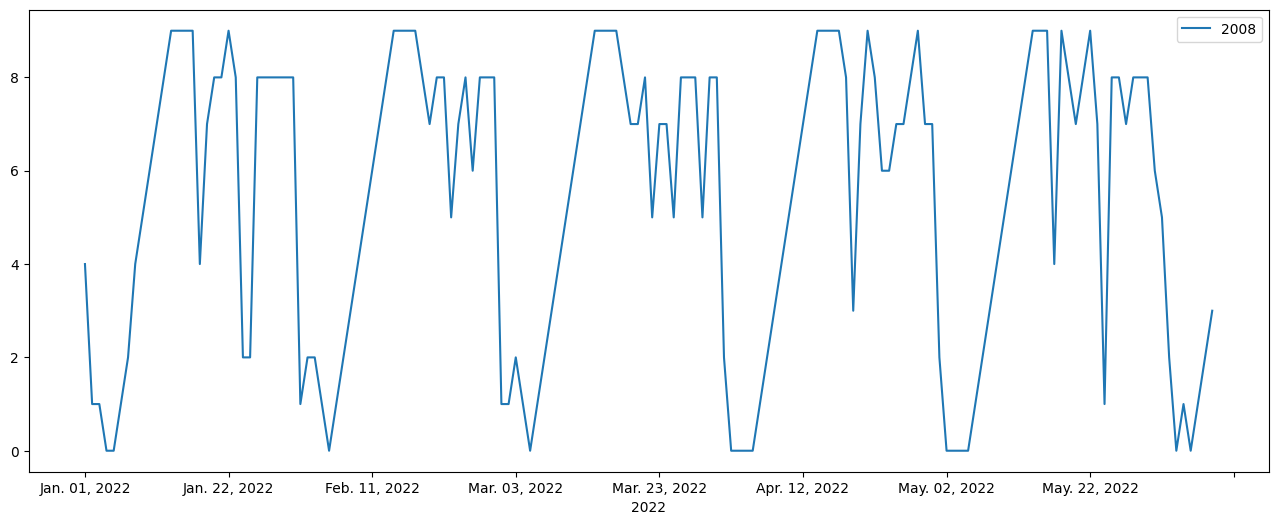

In [ ]:
df_timeline.plot.line(x='2022',y='2008',figsize=(16,6))

<Axes: xlabel='2022', ylabel='2008'>

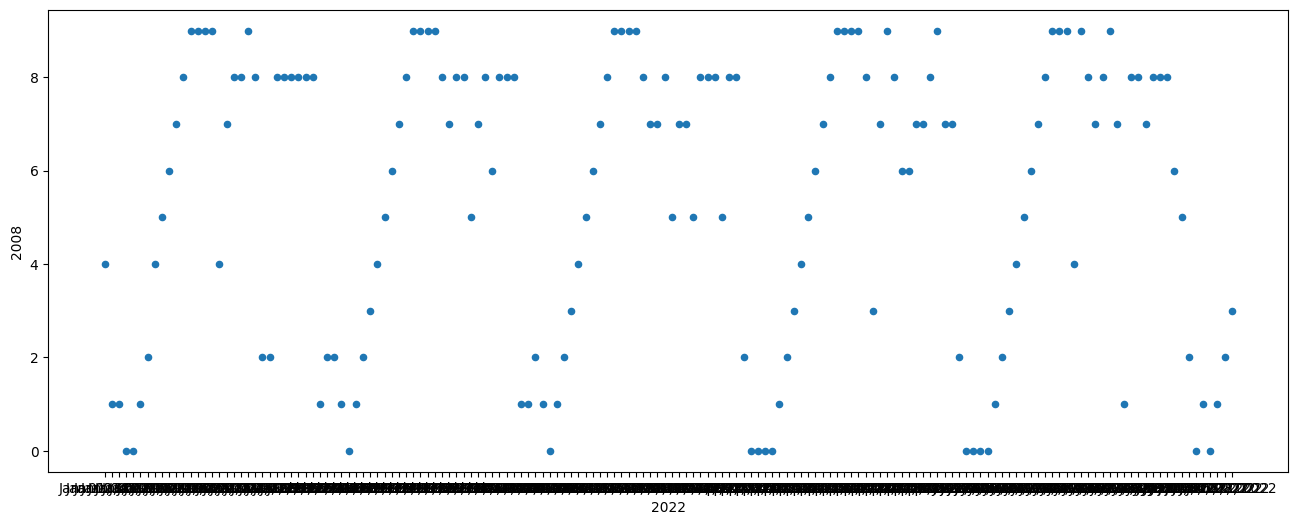

In [ ]:
df_timeline.plot.scatter(x='2022',y='2008',figsize=(16,6))

In [ ]:
df_timeline_2=df_map.groupby(by='2022',sort=False,as_index=False)['2008'].agg(lambda x:x.value_counts().index[0])

<Axes: xlabel='2022'>

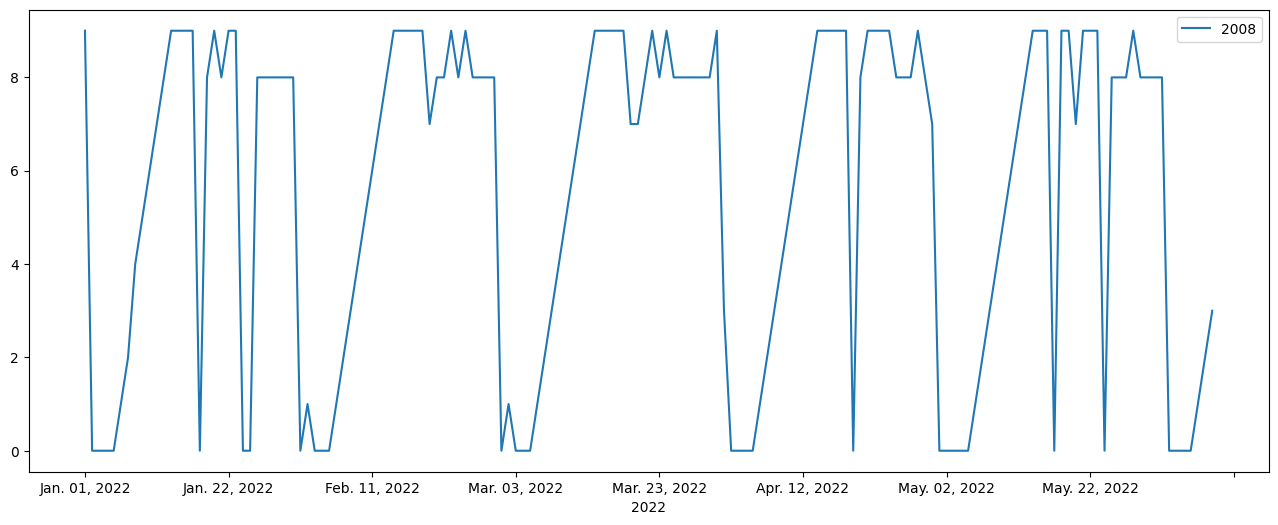

In [ ]:
df_timeline_2.plot.line(x='2022',y='2008',figsize=(16,6))

<Axes: xlabel='2022', ylabel='2008'>

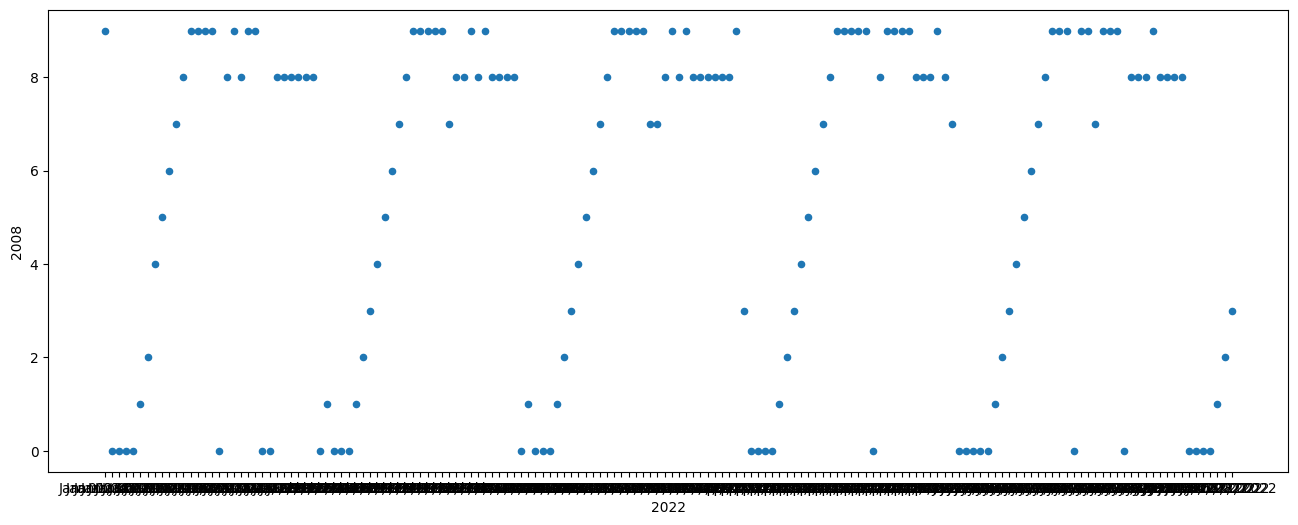

In [ ]:
df_timeline_2.plot.scatter(x='2022',y='2008',figsize=(16,6))

In [ ]:
df_timeline_2

,2022,2008
0,"Jan. 01, 2022",9
1,"Jan. 02, 2022",0
2,"Jan. 03, 2022",0
3,"Jan. 04, 2022",0
4,"Jan. 05, 2022",0
...,...,...
153,"Jun. 04, 2022",0
154,"Jun. 05, 2022",0
155,"Jun. 06, 2022",1
156,"Jun. 07, 2022",2


In [ ]:
from google.colab import files
df_timeline.to_csv('timeline_mean.csv', encoding = 'utf-8-sig')
files.download('timeline_mean.csv')
df_timeline_2.to_csv('timeline_mode.csv', encoding = 'utf-8-sig')
files.download('timeline_mode.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
grouped=df_map.groupby(by='2022',sort=False,as_index=False)

In [ ]:
training_stats_dict=[{'epoch': 1,
  'Training Loss': 2.2630900466764294,
  'Valid. Loss': 2.1825468805101185,
  'Valid. Accur.': 0.125},
 {'epoch': 2,
  'Training Loss': 1.8300936914779045,
  'Valid. Loss': 1.2817550169097052,
  'Valid. Accur.': 0.7708333333333334},
 {'epoch': 3,
  'Training Loss': 0.9241173609688476,
  'Valid. Loss': 0.43979078862402177,
  'Valid. Accur.': 1.0},
 {'epoch': 4,
  'Training Loss': 0.2985893587606984,
  'Valid. Loss': 0.09587811678647995,
  'Valid. Accur.': 1.0},
 {'epoch': 5,
  'Training Loss': 0.09642840131513171,
  'Valid. Loss': 0.04033861433466276,
  'Valid. Accur.': 1.0},
 {'epoch': 6,
  'Training Loss': 0.059294642679191926,
  'Valid. Loss': 0.029333847264448803,
  'Valid. Accur.': 1.0}]


In [ ]:
import pandas as pd

In [ ]:
df_training_stats_dict=pd.DataFrame.from_dict(training_stats_dict)

In [ ]:
df_training_stats_dict

,epoch,Training Loss,Valid. Loss,Valid. Accur.
0,1,2.263090,2.182547,0.125000
1,2,1.830094,1.281755,0.770833
2,3,0.924117,0.439791,1.000000
3,4,0.298589,0.095878,1.000000
4,5,0.096428,0.040339,1.000000
5,6,0.059295,0.029334,1.000000


In [ ]:
df_training_stats_dict=df_training_stats_dict[df_training_stats_dict.columns[1:3]]*100
df_training_stats_dict

,Training Loss,Valid. Loss
0,226.309005,218.254688
1,183.009369,128.175502
2,92.411736,43.979079
3,29.858936,9.587812
4,9.642840,4.033861
5,5.929464,2.933385


<Axes: xlabel='Epochs', ylabel='Loss'>

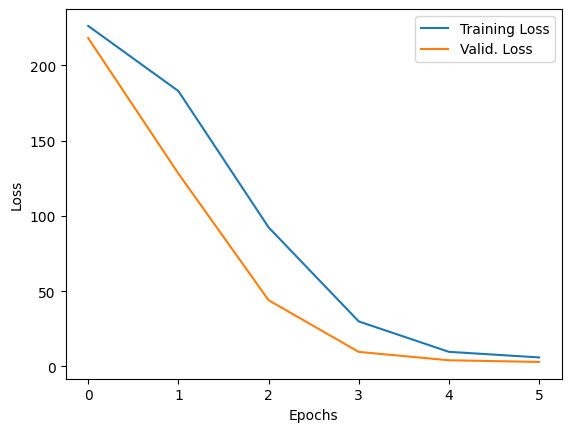

In [ ]:
df_training_stats_dict.plot.line(xlabel="Epochs",ylabel="Loss")